In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import seaborn as sns
import numpy as np

matplotlib.rcParams.update({'font.size': 14})
pd.set_option('display.max_columns', 100)

## Image registry

In [2]:
df = pd.read_csv('/Users/josephking/Documents/sponsored_projects/MERGEN/data/vehicle_classifier/image_registries/train_img_directory.csv')

In [3]:
df.head()

,Make,Model,Category,Source Path,URL,Bboxes,Dims
0,Acura,CL,Car,Acura/CL/2001/f04ed53e11.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[3.0, 56.0, 252.0, 138.0, 0.88232421875]","[194.0, 259.0, 3.0]"
1,Acura,CL,Car,Acura/CL/2001/6084dddd71.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[3.0, 54.0, 248.0, 157.0, 0.859375]","[194.0, 259.0, 3.0]"
2,Acura,CL,Car,Acura/CL/2001/723a443ab2.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[16.0, 48.0, 239.0, 152.0, 0.931640625]","[194.0, 259.0, 3.0]"
3,Acura,CL,Car,Acura/CL/2001/cb6d1e23cb.jpg,https://www.carspecs.us/photos/7d756cd1c893894...,"[29.0, 152.0, 1787.0, 920.0, 0.89453125]","[994.0, 1836.0, 3.0]"
4,Acura,CL,Car,Acura/CL/2001/ede0361fca.jpg,https://encrypted-tbn0.gstatic.com/images?q=tb...,"[37.0, 60.0, 254.0, 139.0, 0.9306640625]","[168.0, 300.0, 3.0]"


### Vehicle makes among scraped images

In [4]:
df.Make.unique()

array(['Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Fiat', 'Ford', 'GMC', 'HUMMER', 'Honda',
       'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'Kia', 'Land Rover',
       'Lexus', 'Lincoln', 'MINI', 'Mazda', 'Mercedes-Benz', 'Mercury',
       'Mitsubishi', 'Nissan', 'Pontiac', 'Porsche', 'RAM', 'Saab',
       'Saturn', 'Scion', 'Subaru', 'Suzuki', 'Tesla', 'Toyota',
       'Volkswagen', 'Volvo', 'smart'], dtype=object)

In [5]:
df.Make.nunique()

40

### Make-models among scraped images

In [6]:
len(df[['Make', 'Model']].drop_duplicates())

574

# Image Counts per Make-Model with YOLOv5 (XL) Bounding Boxes

We use the YOLOv5 algorithm, specifically the extra large (XL) model variant, to tag relevant objects in images. We keep objects that the algorithm labels as either a car, truck, or bus and whose bounding box confidence was >= 0.50. If multiple such objects are identified in a particular image, we keep the one with the largest bounding box area. Below we analyze the distribution of bounding box area and confidence.

In [7]:
df['Bboxes'] = df['Bboxes'].apply(lambda x: list(ast.literal_eval(x)))
subset = df.loc[df.Bboxes.str.len() != 0].reset_index(drop=True)  # restrict to rows with bounding boxes

In [8]:
df.shape

(664678, 7)

In [9]:
subset.shape

(631973, 7)

In [10]:
print("Number of images without a bounding box: {:,}".format(len(df) - len(subset)))
print("Share of images without a bounding box: {:.2%}".format(1- (len(subset)/len(df))))

Number of images without a bounding box: 32,705
Share of images without a bounding box: 4.92%


### Distribution of images per class, conditional on having a YOLOv5 bounding box

In [11]:
make_model_reduced = pd.DataFrame((subset['Make'] + ' ' + subset['Model']), columns=['Make_Model'])
make_model_reduced['Count'] = 1
make_model_reduced = make_model_reduced.groupby('Make_Model')['Count'].count().reset_index()
make_model_reduced['Count'].describe()

count      574.000000
mean      1100.998258
std       1206.032990
min         74.000000
25%        354.000000
50%        708.500000
75%       1386.750000
max      11080.000000
Name: Count, dtype: float64

#### Distribution of confidence, conditional on having a YOLOv5 bounding box

In [12]:
subset['conf'] = subset['Bboxes'].apply(lambda x: x[-1])

In [13]:
subset['conf'].describe()

count    631973.000000
mean          0.826671
std           0.128676
min           0.250244
25%           0.790527
50%           0.872559
75%           0.912598
max           0.962891
Name: conf, dtype: float64

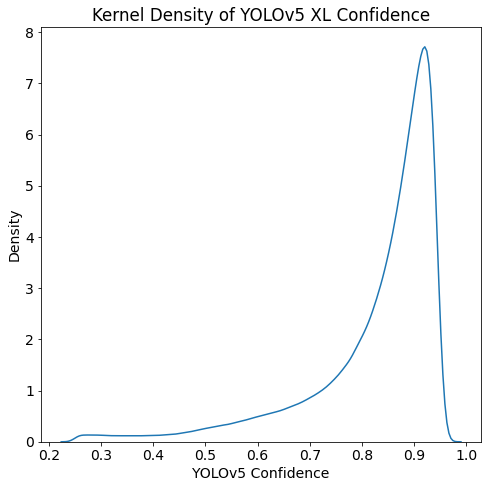

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
fig.set_facecolor('white')
sns.kdeplot(subset['conf'])
plt.title('Kernel Density of YOLOv5 XL Confidence')
plt.xlabel('YOLOv5 Confidence')
plt.tight_layout()
plt.savefig('../figs/kdeplot_yolo_confidence.png', dpi=80)
plt.show()

#### Note - at training time we restrict to images with >= 0.50 confidence, yielding 609,265 images

### Distribution of YOLOv5 bounding box area

In [15]:
subset['area'] = subset['Bboxes'].apply(lambda x: (x[3] - x[1]) * (x[2] - x[0])).astype(int) # Format: xyxy
subset = subset.sort_values(by='area').reset_index(drop=True)

In [16]:
subset['area'].describe()

count    6.319730e+05
mean     1.736548e+05
std      3.849969e+05
min      2.400000e+01
25%      2.454400e+04
50%      3.451500e+04
75%      1.440000e+05
max      1.334594e+07
Name: area, dtype: float64

In [17]:
ecdf = subset['area'].cumsum() / subset['area'].sum()
ecdf.index = np.sqrt(subset['area'])

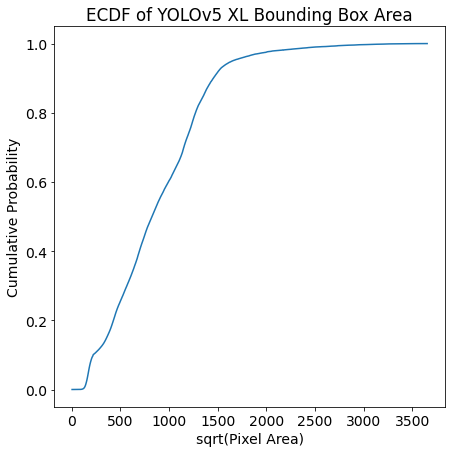

In [18]:
fig, ax = plt.subplots(figsize=(7,7))
fig.set_facecolor('white')
plt.plot(ecdf)
plt.xlabel('sqrt(Pixel Area)')
plt.ylabel("Cumulative Probability")
plt.title("ECDF of YOLOv5 XL Bounding Box Area")
plt.savefig('../figs/ecdf_bounding_box_area.png', dpi=80)
plt.show()

In [19]:
thresh = subset['area'].quantile(0.01)
print(round(thresh))
print(f"Equivalent to {round(np.sqrt(thresh))} x {round(np.sqrt(thresh))} image")

8907
Equivalent to 94 x 94 image


### Restrict to images whose bounding box area is > 1st percentile

In [20]:
subset = subset.loc[subset['area'] > thresh]

In [21]:
subset.shape

(625653, 9)

In [22]:
subset[subset.conf >= 0.5].shape

(603899, 9)

### Distribution of images per class, conditional on adequately-sized bounding box

In [23]:
make_model_reduced = pd.DataFrame((subset['Make'] + ' ' + subset['Model']), columns=['Make_Model'])
make_model_reduced['Count'] = 1
make_model_reduced = make_model_reduced.groupby('Make_Model')['Count'].count().reset_index()
make_model_reduced['Count'].describe()

count      574.000000
mean      1089.987805
std       1196.276371
min         72.000000
25%        346.000000
50%        704.500000
75%       1377.000000
max      11015.000000
Name: Count, dtype: float64

In [24]:
img_count = make_model_reduced['Count'].sort_values().reset_index(drop=True)
ecdf_img_count = img_count.cumsum() / img_count.sum()
ecdf_img_count.index = img_count

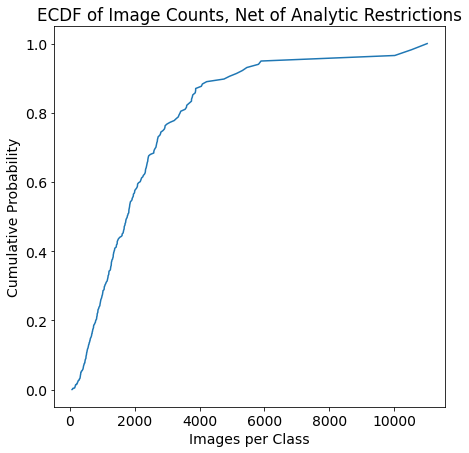

In [25]:
fig, ax = plt.subplots(figsize=(7,7))
fig.set_facecolor('white')
plt.plot(ecdf_img_count)
plt.xlabel('Images per Class')
plt.ylabel("Cumulative Probability")
plt.title("ECDF of Image Counts, Net of Analytic Restrictions")
plt.savefig('../figs/ecdf_img_count.png', dpi=80)
plt.show()

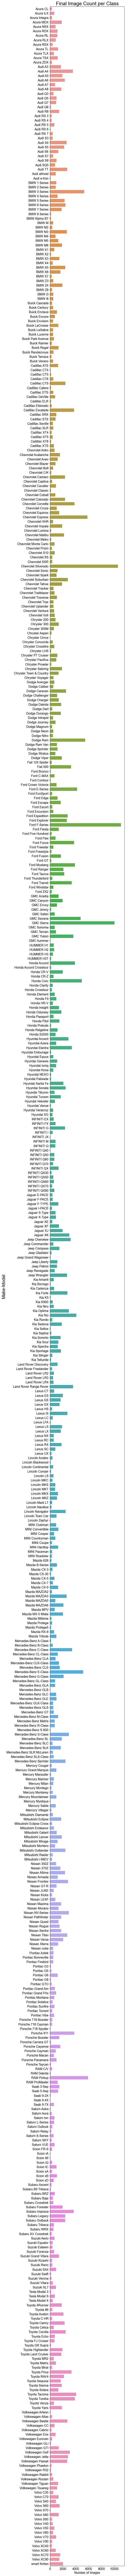

In [26]:
fig, ax = plt.subplots(figsize=(8,160), dpi=80)
fig.set_facecolor('white')
sns.set(font_scale=1.1)
sns.barplot(data=make_model_reduced, x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Final Image Count per Class", fontsize=22)
plt.tight_layout()
plt.savefig('../figs/final_img_count_class.png', dpi=80)
plt.show()

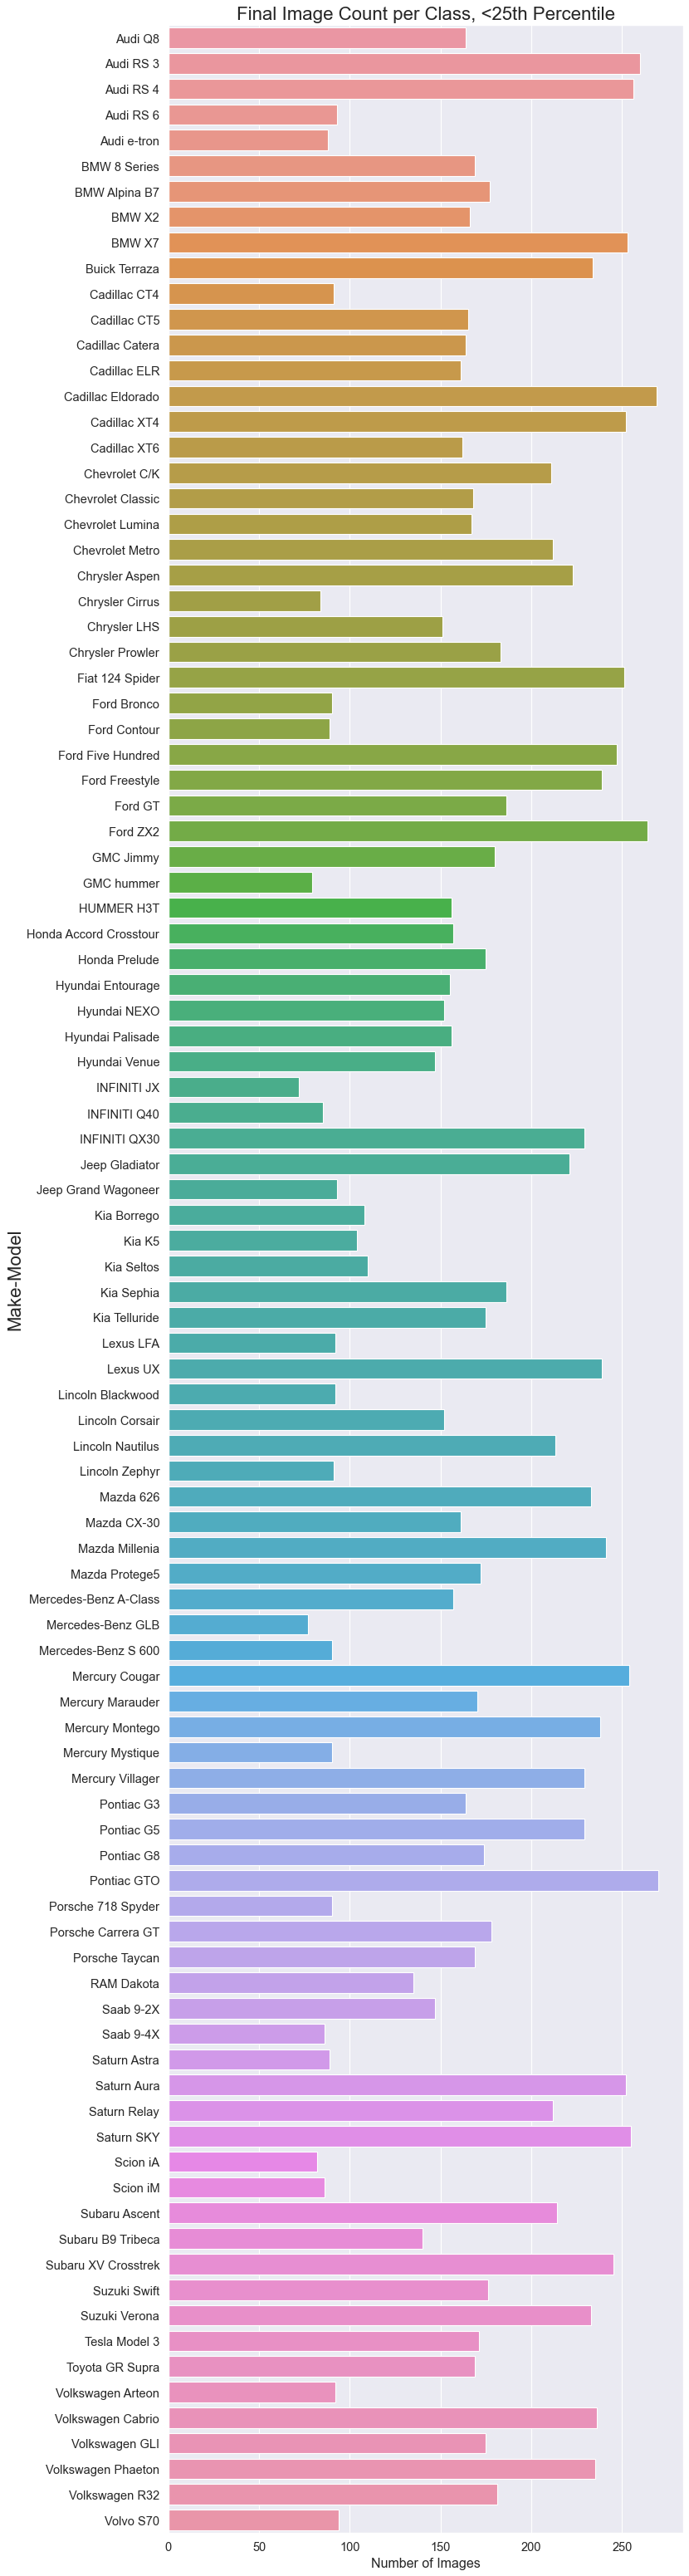

In [27]:
figure(figsize=(10, 50), dpi=80)
sns.set(font_scale=1.2)
sns.barplot(data=make_model_reduced.loc[make_model_reduced['Count'] < 287], x='Count', y='Make_Model')
plt.xlabel("Number of Images")
plt.ylabel("Make-Model", fontsize=20)
plt.title("Final Image Count per Class, <25th Percentile", fontsize=20)
plt.show()